In [1]:
import os
import glob

import pyabf
import numpy as np
from scipy.ndimage import gaussian_filter1d
from matplotlib import pyplot as plt

In [2]:
class Signal:
    def __init__(self, path):
        # basic info
        self.path = path
        self.name = None
        self.posORneg = None
        self.dt = None
        self.computationSequence = None
        # additional info
        self.signal = None
    
    def saveCSV(save_path):
        return

def genStrNum(str_num, add):
    newOne = int(str_num) + add
    if newOne < 10:
        newOne = str(newOne)
        return '0'+newOne
    else:
        return str(newOne)

def setInstanceInit(instance, **params):
    # params :: name, dt, ad1, ad2, cmpSeq
    name, pORn, dt, cmpSeq = params.items()
    _, instance.name = name
    _, instance.posORneg = pORn
    _, instance.dt = dt
    _, instance.computationSequence = cmpSeq

In [3]:
to_ws = '/Users/ryotaro/Desktop/kamei/'
rawData_path = to_ws + '20211004/'
dir_save = 'result/'

simulation_state = 'control'
#simulation_state = 'withoutIn'

abf = '.abf'
csv = '.csv'
jpg = '.jpg'

if simulation_state == 'control':
    # 03-13 :: control
    start_index = '03'
else:
    # 14-24 :: withoutIn
    start_index = '14'

sampling_freq = 200000
sampling_interval = 5.0 * 10**-6
fs = 500
fig_xlim, fig_ylim = (0,0.2), (-0.3,0.3)

signalParam = [{'name':'0', 'p&n':None,'dt':None,'cmpSeq':4},
                          {'name':'p5', 'p&n':'+','dt':1000,'cmpSeq':5},
                          {'name':'m5', 'p&n':'-','dt':1000,'cmpSeq':3},
                          {'name':'p10', 'p&n':'+','dt':2000,'cmpSeq':6},
                          {'name':'m10', 'p&n':'-','dt':2000,'cmpSeq':2},
                          {'name':'p20', 'p&n':'+','dt':4000,'cmpSeq':7},
                          {'name':'m20', 'p&n':'-','dt':4000,'cmpSeq':1},
                          {'name':'p40', 'p&n':'+','dt':8000,'cmpSeq':8},
                          {'name':'m40', 'p&n':'-','dt':8000,'cmpSeq':0}]

## use for result fig
row_time = [-40, -20, -10, -5, 0, 5, 10, 20, 40]

In [4]:
## create a directory for saving
dir_save_full =rawData_path+dir_save+simulation_state+'/'
os.makedirs(dir_save_full, exist_ok=True)

In [5]:
instance_list = []
for file in sorted(glob.glob(rawData_path+'*'+abf)):
    file_num = file[-6:-4]
    # 03 : 0[ms]
    if file_num== start_index:
        signal = Signal(file)
        setInstanceInit(signal, **signalParam[0])
        instance_list.append(signal)
    # 04 : DD
    elif file_num== genStrNum(start_index, 1):
        signal = Signal(file)
        signal.name = simulation_state+"_DD"
        instance_list.append(signal)
    # 05 : MD
    elif file_num == genStrNum(start_index, 2):
        signal = Signal(file)
        signal.name = simulation_state+"_MD"
        instance_list.append(signal)
    # 06 : +5[ms]
    elif file_num == genStrNum(start_index, 3):
        signal = Signal(file)
        setInstanceInit(signal, **signalParam[1])
        instance_list.append(signal)
    # 07 : +10[ms]
    elif file_num == genStrNum(start_index, 4):
        signal = Signal(file)
        setInstanceInit(signal, **signalParam[3])
        instance_list.append(signal)
    # 08 : +20[ms]
    elif file_num == genStrNum(start_index, 5):
        signal = Signal(file)
        setInstanceInit(signal, **signalParam[5])
        instance_list.append(signal)
    # 09 : +40[ms]
    elif file_num == genStrNum(start_index, 6):
        signal = Signal(file)
        setInstanceInit(signal, **signalParam[7])
        instance_list.append(signal)
    # 10 : -5[ms]
    elif file_num == genStrNum(start_index, 7):
        signal = Signal(file)
        setInstanceInit(signal, **signalParam[2])
        instance_list.append(signal)
    # 11 : -10[ms]
    elif file_num == genStrNum(start_index, 8):
        signal = Signal(file)
        setInstanceInit(signal, **signalParam[4])
        instance_list.append(signal)
    # 12 : -20[ms]
    elif file_num == genStrNum(start_index, 9):
        signal = Signal(file)
        setInstanceInit(signal, **signalParam[6])
        instance_list.append(signal)
    # 13 : -40[ms]
    elif file_num == genStrNum(start_index, 10):
        signal = Signal(file)
        setInstanceInit(signal, **signalParam[8])
        instance_list.append(signal)

simulation state :  control
-3dB cutoff freq[Hz] :  500


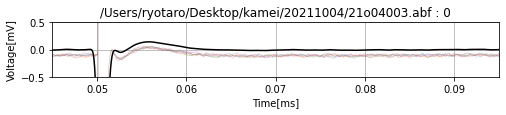

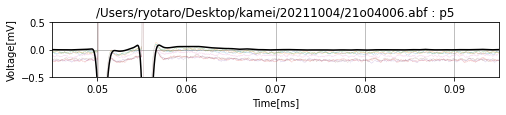

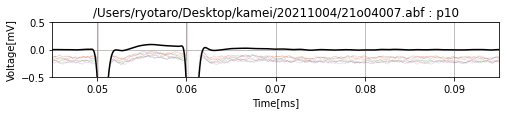

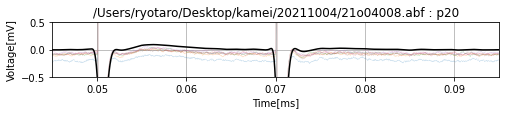

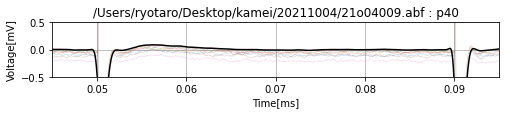

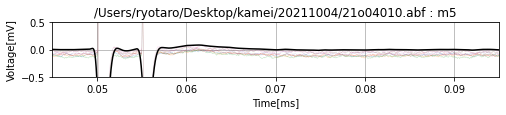

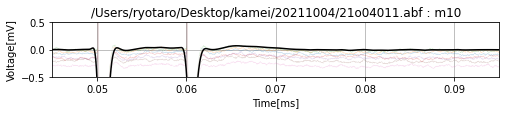

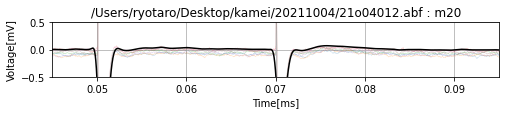

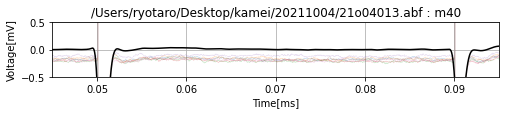

In [6]:
print("simulation state : ", simulation_state)
print("-3dB cutoff freq[Hz] : ", fs)

for ins in instance_list:
    # グラフ描画フラグ。いらなかったらFalseにしてください
    plt_flag = True
    abf = pyabf.ABF(ins.path)
    if ins.computationSequence is None:
        plt_flag = False
    else:
        fig, ax = plt.subplots(figsize=(8, 1))
    sweep_num = len(abf.sweepList)
    sweep_size = len(abf.sweepX)
    lowpass_list = np.empty((sweep_num, sweep_size), dtype=np.float64)
    ## 0合わせ時の計算用変数(default : 0[ms] -> 0.04[ms] )
    ave_sampling_range = 0.04
    dt_top, dt_bottom = 0, int(ave_sampling_range*sampling_freq)

    for sweepNumber in abf.sweepList:
        abf.setSweep(sweepNumber)
        dataX, dataY = abf.sweepX, abf.sweepY
        if plt_flag:
            plt.plot(dataX, dataY, linewidth = 0.2, alpha=0.2)
        
        #基準合わせ
        ave = np.sum(dataY[dt_top:dt_bottom]) / len(dataY[dt_top:dt_bottom])
        dataY = dataY + np.abs(ave)
    
        #ガウシアンローパスフィルタ
        sigma = sweep_size / (fs*2*np.pi)
        data_lowpass = gaussian_filter1d(dataY, sigma)
        lowpass_list[sweepNumber] = data_lowpass
    
    #加算平均
    addave = (np.sum(lowpass_list, axis=0) / sweep_num)
    ins.signal = [dataX, addave]
    if plt_flag:
        plt.plot(dataX, addave, color="black")
    
        ax.set_xlabel("Time[ms]")
        ax.set_ylabel("Voltage[mV]")
        ax.set_title(ins.path+' : '+ins.name)
        plt.grid()
        plt.axis([0.045, 0.095, -0.5, 0.5])
        plt.show()

Save as :: /Users/ryotaro/Desktop/kamei/20211004/result/control/control_DDandMD.jpg


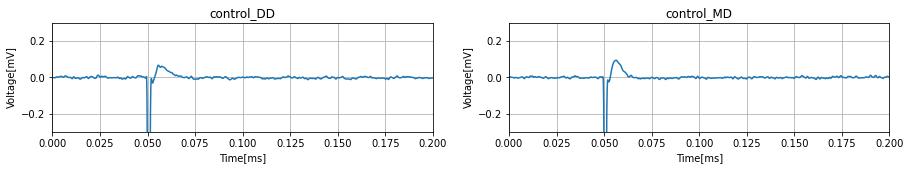

In [7]:
insDD, insMD = [ins for ins in instance_list if (ins.computationSequence is None)]
## figure init
fig = plt.figure(figsize=(15, 2))
ax_DD = fig.add_subplot(1, 2, 1, title=insDD.name, xlim=fig_xlim, ylim=fig_ylim)
ax_MD = fig.add_subplot(1, 2, 2, title=insMD.name, xlim=fig_xlim, ylim=fig_ylim)

ax_DD.set_xlabel("Time[ms]")
ax_DD.set_ylabel("Voltage[mV]")
ax_DD.grid()
ax_MD.set_xlabel("Time[ms]")
ax_MD.set_ylabel("Voltage[mV]")
ax_MD.grid()

# DD
DD = insDD.signal[1]
row = len(DD)
zerosDD = np.zeros(row)
ave_bias = np.abs(np.mean(zerosDD))
DD = DD + ave_bias

# MD
MD= insMD.signal[1]
MD = MD + ave_bias

# show DD and MD
ax_DD.plot(insDD.signal[0], DD)
ax_MD.plot(insDD.signal[0], MD)

#save fig
print('Save as :: {0}'.format(dir_save_full+simulation_state+'_DDandMD'+jpg))
fig.savefig(dir_save_full+simulation_state+'_DDandMD'+jpg)

plt.show()

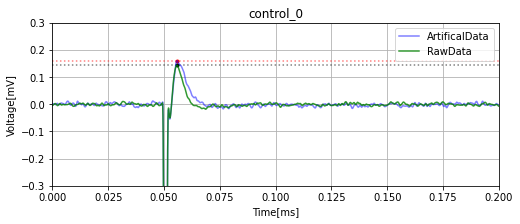

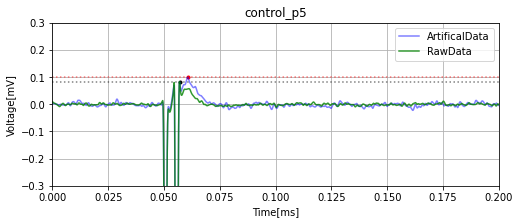

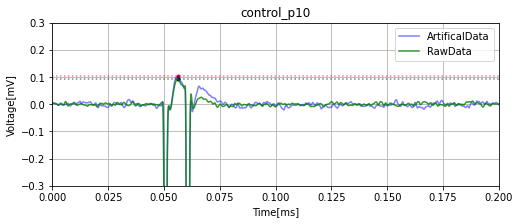

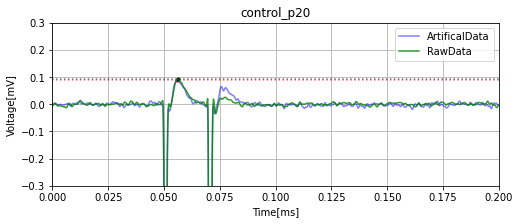

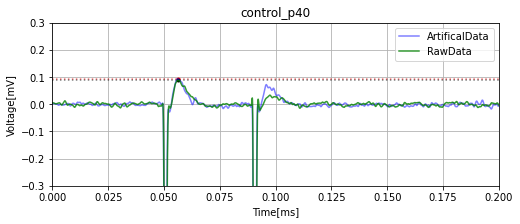

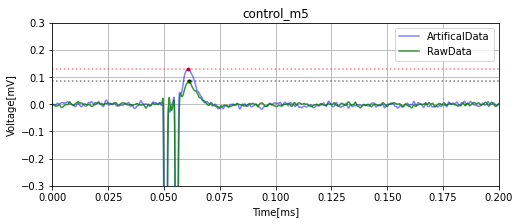

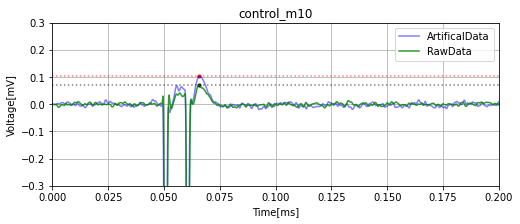

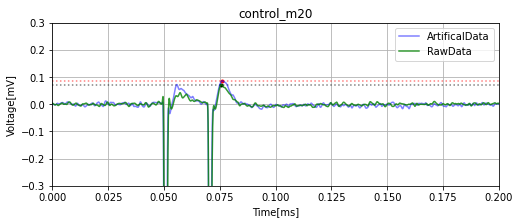

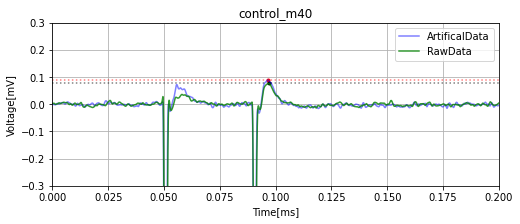

SumResult(%) : [84.5 83.4 74.1 78.6 80.5 66.4 71.4 84.3 91.4]
PeakResult(%): [ 85.7  83.1  69.   65.5  89.4  83.5  91.2 102.   93.6]


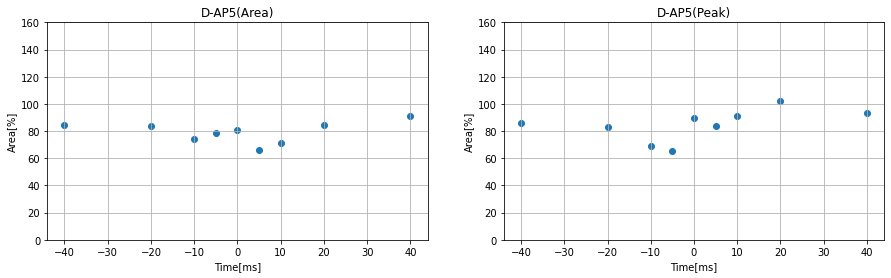

In [8]:
## init variables
#理論波形作成用
ArtificalData = np.zeros(row)

#ピーク値格納用
afPeakResult = np.zeros(9)
rdPeakResult = np.zeros(9)
summennseki1=np.zeros(9) #面積比格納(理論値)
summennseki2=np.zeros(9) #面積比格納(実測値)

#ピーク値の比の格納用
PeakResult = np.zeros(9)

for ins in [ins for ins in instance_list if (ins.computationSequence is not None)]:
    fig, ax = plt.subplots(figsize=(8, 3))
    pm_flag = ins.posORneg
    name = ins.name
    dt = ins.dt
    index = ins.computationSequence
    # 0 (ms)
    if pm_flag is None:
        ArtificalData = DD + MD
    # -5, -10, -20, -40 (ms)
    elif pm_flag == '-':
        i, j = 0, 0
        for num1 in range(dt):
            ArtificalData[i] = DD[i]
            i += 1
        for num2 in range(row-dt):
            ArtificalData[i] = DD[i] + MD[j]
            i += 1
            j += 1
    # +5, +10, +20, +40 (ms)
    elif pm_flag == '+':
        i, j = 0, 0
        for num1 in range(dt):
            ArtificalData[i] = MD[i]
            i += 1
        for num2 in range(row-dt):
            ArtificalData[i] = MD[i] + DD[j]
            i += 1
            j += 1
    
    RawData = ins.signal[1] + ave_bias
    
    afPeakResult[index] = ArtificalData.max()
    rdPeakResult[index] = RawData.max()
    afdMax_index = ArtificalData.argmax()
    rdMax_index = RawData.argmax()
    
    displayRange = (0, ins.signal[0][-1])
    plt.hlines(ArtificalData[afdMax_index], *displayRange, "r", linestyle=":", alpha=0.5)
    plt.hlines(RawData[rdMax_index], *displayRange, "k", linestyle=":", alpha=0.5)
    plt.plot(ins.signal[0][afdMax_index], ArtificalData[afdMax_index], marker='.', color="r")
    plt.plot(ins.signal[0][rdMax_index], RawData[rdMax_index], marker='.', color="k")
    
    summennseki1[index] = np.sum(np.abs(ArtificalData))
    summennseki2[index] = np.sum(np.abs(RawData))
    
    #show fig
    plt.plot(ins.signal[0], ArtificalData, label="ArtificalData", color="b", alpha=.5)
    plt.plot(ins.signal[0], RawData, label="RawData", color="g", alpha=.8)
    plt.title(simulation_state+'_'+name)
    ax.set_xlabel("Time[ms]")
    ax.set_ylabel("Voltage[mV]")
    plt.xlim(fig_xlim)
    plt.ylim(fig_ylim)
    plt.legend()
    plt.grid()
    #save fig
    plt.savefig(dir_save_full+simulation_state+'_'+name+jpg)
    plt.show()
    
PeakResult = rdPeakResult / afPeakResult
SumResult = summennseki2 / summennseki1

np.set_printoptions(threshold=np.inf)
print("SumResult(%) : {0}".format(np.round(SumResult*100, decimals=1)))
print("PeakResult(%): {0}".format(np.round(PeakResult*100, decimals=1)))

######## RESULT ########
fig = plt.figure(figsize=(15, 4))
if simulation_state == 'control':
    title_area = 'D-AP5(Area)'
    title_peak = 'D-AP5(Peak)'
    save_title = "D-AP5_result"
else:
    title_area = 'D-AP5+picrotoxin(Area)'
    title_peak = 'D-AP5+picrotoxin(Peak)'
    save_title = "D-AP5+picrotoxin_result"
    
ax_area = fig.add_subplot(1, 2, 1, title=title_area, ylim=(0, 160))
ax_peak = fig.add_subplot(1, 2, 2, title=title_peak, ylim=(0, 160))

ax_area.scatter(row_time, SumResult*100)
ax_peak.scatter(row_time, PeakResult*100)

ax_area.set_xlabel("Time[ms]")
ax_area.set_ylabel("Area[%]")
ax_area.grid()

ax_peak.set_xlabel("Time[ms]")
ax_peak.set_ylabel("Area[%]")
ax_peak.grid()
plt.show()

#save fig
fig.savefig(dir_save_full+simulation_state+'_'+save_title+jpg)